In [1]:
import os

import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import tensorboard

from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm

# for model evaluation
import numpy as np

from models.vgg import VGG
        
from utils import load_cifar10, visualize_cifar10, plot_confusion_matrix


seed = 420
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
# hyperparameters for training
batch_size = 32
num_epochs = 30
lr = 1e-3
weight_decay = 15e-5
grad_clip = 0.001

data_mean, data_std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
num_workers = os.cpu_count()
print(num_workers)

# CIFAR-10 Classes
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda
32


# Training and visualization of the dataset

In [3]:
if device == "cuda":
    train_loader, val_loader = load_cifar10(root_dir='data', batch_size=batch_size, num_workers=num_workers, augment_data=False, pin_memory=True)
else:
    train_loader, val_loader = load_cifar10(root_dir='data', batch_size=batch_size, num_workers=num_workers, augment_data=False, pin_memory=False)

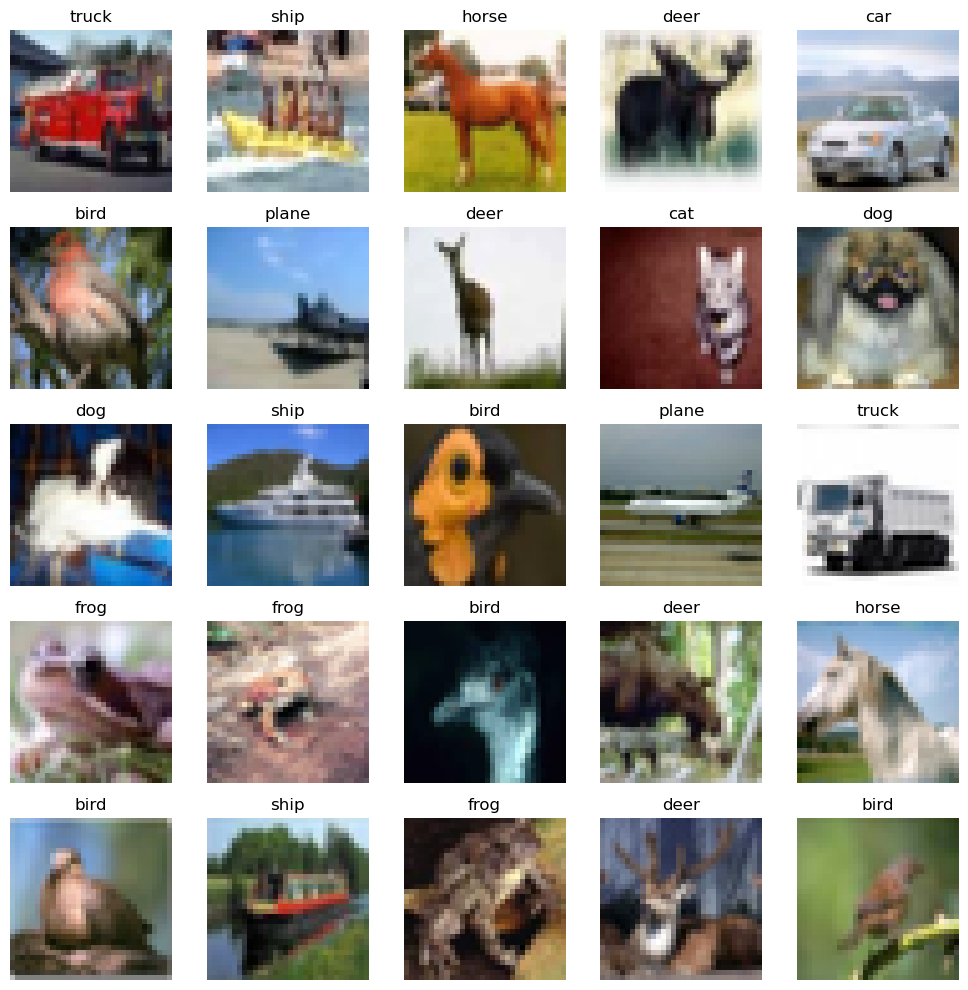

In [4]:
visualize_cifar10(train_loader, class_names)

# 1.1 ResNet Image Classifier


## a) Basic Block Implementation



![BasicBlock.png](BasicBlock.png "Basic Block")

<mark>*TODO*: Initialize the layers of the basic block.</mark> 
 
The basic block consists of two parts:
    
1. **Residual layer:**                             
    * The residual layer comprises **2 convolutions** using **3x3 kernel** and **padding of 1**. 
    * The first conv layer uses **'stride'** as stride and the second one a **stride of 1**.   
    * After each convolution we need a **batch norm layer**.
    * After the first convolution we have **ReLU activation**.
    * After the second convolution we have **no activation**.         
2. **Residual connection:**                         
    * The residual connection is a **skip connection** that combines the **input of the block** with the **output of the last conv layer**.           
    * If the **input and output channels are not the same** or the **stride is not one**, we need to use a **1x1 conv layer** with a **stride of 'stride'** and a **batch norm layer** to downsample the input (this is already implemented for you below).   
    
* (You can set **bias=False** for all conv layers.) 

<mark>*TODO*: Implement the **forward model** that passes the input through the complete network.</mark> 
Don't forget to **activate the output of the residual connection**.


In [16]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # TODO: Initialize the layers of the basic block.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)       
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Residual connection
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        #################################################
        # TODO: Implement the forward pass of the basic #
        # ResNet block. Use 'cbr' order, where 'c' is   #
        # conv, 'b' is batchnorm, and 'r' is relu.      #
        # Activate the output AFTER adding the residual.#
        #################################################
        
        #################################################
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.residual(x)
        out = self.relu(out)

        return out

# b) ResNet Implementation



![BasicBlock.png](ResNet.png "Basic Block")

<mark>*TODO*: Initialize the layers of the ResNet model.</mark> 
1. **Input layer:**                                  
    * Consists of a **conv-batchnorm-relu** block.  
    * The conv layer uses **3x3 kernel**, **padding of 1** and a **stride of 1**.        
    * Not for all implementations a 3x3 kernel is used, e.g., the original implementation uses a 7x7 kernel followed by max pooling.  
        If you want to, you can also try out different kernel sizes and combinations.          
2. **ResNet layers:**                               
    * Make **4 layers** with the number of blocks as specified by **'num_blocks'**.  
      For this, you can use the function `_make_layer`, which makes a block of the class specified in the parameter `block`. For this, we later pass the parameter `block=BasicBlock` to use the Basic block you already implemented.  
    * After the **4 layers**, use **Adaptive average pooling** with an **output size of 1x1**.                
    * Initialize a **linear layer** to map from channels to **num_classes**.  

<mark>*TODO*: Implement the **forward model** that passes the input through the complete network.</mark> 
 
 Be aware that the linear layer requires a 1D input, while the convolutional layer returns a 2D output.


In [17]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # TODO: Initialize the layers of the ResNet model 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512, num_classes)
    
    


    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #################################################
        # TODO: Implement the forward pass of ResNet.   #
        # Use 'cbr' order, where 'c' is conv, 'b' is    #
        # batchnorm, and 'r' is relu.                   #
        # Resize the output after the average pooling   #
        # layer to 1D tensor before applying the linear #
        # layer.                                        #
        #################################################

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        # Reshape the output to 1D tensor
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        #################################################
        return x

    def save_checkpoint(self, epoch, accuracy, ckptpath="checkpoint"):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'accuracy': accuracy,
        }
        ckptpath = os.path.join(ckptpath, "checkpoint_{}_{:.4f}.pth".format(epoch, accuracy))
        # Save the dictionary to file
        torch.save(checkpoint, ckptpath)

    def load_checkpoint(self, ckptpath, map_location=None):
        # Load the saved file
        checkpoint = torch.load(ckptpath, map_location=map_location)
        
        # Restore model and optimizer state
        self.load_state_dict(checkpoint['model_state_dict'])

# c) Training and Validation

Now that you have implemented the model we can train it for image classification on the provided data set.
Implement the training and validation loop at the specified positions. You can use the provided comments as guidance.

<mark>*TODO*: Implement the training and validation loops.</mark>

In [18]:
def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in (pbar := tqdm(enumerate(dataloader), total=len(dataloader), ncols=800, unit='batches', leave=False)):
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        #################################################
        # TODO: Implement the training loop.            #
        # 1) Forward pass:                              #
        #      - Calculate the model prediction using   #
        #        the input data                         #
        #      - Calculate the loss using the predic-   #
        #        tions and true targets                 #
        # 2) Backward pass:                             #
        #      - Ensure zero gradients                  #
        #      - Perform backward pass to calculate gra-#
        #        dients                                 #
        #      - Update weights                         #
        # 3) Track loss and number of correctly classi- #
        #    fied samples                               #
        #      - Add loss to total_loss                 #
        #      - Calculate predicted class labels       #
        #      - Add targets.size to total and the num- #
        #        of correctly classified samples to     #
        #        correct                                #
        #################################################


        out = model(inputs)
        loss = criterion(out, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = out.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()



        #################################################
       
        #pbar.set_description(f"Iteration: {batch_idx}")
        #pbar.set_postfix_str(f"Train Loss: {loss.item():.4f} | Train Acc: {100* correct / total:.2f} | LR: {optimizer.param_groups[0]['lr']}")        
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    
    if scheduler:
        scheduler.step(avg_loss)
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (inputs, targets) in (pbar := tqdm(enumerate(dataloader), total=len(dataloader), ncols=800, unit='batches', leave=False)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #################################################
            # TODO: Implement the validation loop.          #
            # 1) Forward pass:                              #
            #      - Calculate the model prediction using   #
            #        the input data                         #
            #      - Calculate the loss using the predic-   #
            #        tions and true targets                 #
            # 2) Track loss and number of correctly classi- #
            #    fied samples                               #
            #      - Add loss to total_loss                 #
            #      - Calculate predicted class labels       #
            #      - Add targets.size to total and the num- #
            #        of correctly classified samples to     #
            #        correct                                #
            #################################################
            out = model(inputs)
            loss = criterion(out, targets)
            total_loss += loss.item()
            _, predicted = out.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
            #################################################
            #pbar.set_description(f"Iteration: {batch_idx}")
            #pbar.set_postfix_str(f"Valid Loss: {loss.item():.4f} | Valid Acc: {100* correct / total:.2f}")
            
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [8]:
# load tensorboard to visualize the training process
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 44598), started 7:43:53 ago. (Use '!kill 44598' to kill it.)

<mark>*TODO*: Train the preimlemented VGG model.</mark>

For this you do not need to implement anything. Just run the code below.

In [9]:
# Setup model architecture
vgg = VGG(3, 10)

if device == "cuda":
    vgg = vgg.to(device)
    print("Using GPU")

# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.3, patience=3, threshold=0.09)

summary(vgg, (3, 32, 32), batch_size=batch_size, device=device)

Using GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 32, 32]             448
              ReLU-2           [32, 16, 32, 32]               0
            Conv2d-3           [32, 16, 32, 32]           2,320
              ReLU-4           [32, 16, 32, 32]               0
         MaxPool2d-5           [32, 16, 16, 16]               0
            Conv2d-6           [32, 32, 16, 16]           4,640
              ReLU-7           [32, 32, 16, 16]               0
            Conv2d-8           [32, 32, 16, 16]           9,248
              ReLU-9           [32, 32, 16, 16]               0
        MaxPool2d-10             [32, 32, 8, 8]               0
          Flatten-11                 [32, 2048]               0
           Linear-12                 [32, 2048]       4,196,352
             ReLU-13                 [32, 2048]               0
          Dropout-14         

In [ ]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
ckptpath = os.path.join(writer.log_dir, "checkpoints_vgg")
os.makedirs(ckptpath, exist_ok=True)

# Metric to watch
best_valid_acc = 0.0

# Training loop
for epoch in (pbar := tqdm(range(num_epochs), unit='epoch')):
    pbar.set_description(f"Epoch {epoch + 1}")

    train_loss, train_acc = train(vgg, train_loader, optimizer, scheduler, loss_function, device)
    valid_loss, valid_acc = validate(vgg, val_loader, loss_function, device)

    writer.add_scalars('losses', {'train': train_loss, 'valid': valid_loss}, global_step=epoch)
    writer.add_scalars('accuracies', {'train': train_acc, 'valid': valid_acc}, global_step=epoch)
    pbar.set_postfix_str(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}")


    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        vgg.save_checkpoint(epoch, accuracy=valid_acc, ckptpath=ckptpath)

Epoch 30: 100%|██████████| 30/30 [01:42<00:00,  3.40s/epoch, Valid Loss: 1.0195 | Valid Acc: 71.21]


<mark>*TODO*: Train your ResNet model.</mark>

For this you do not need to implement anything. Just run the code below. However, you are encouraged to look through the code.

In [19]:
# Setup model architecture
resnet = ResNet(BasicBlock, num_blocks=[1, 2, 2, 1], num_classes=10)
if device == "cuda":
    resnet = resnet.to(device)
    print("Using GPU")
# Loss function, optimizer, and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.3, patience=3, threshold=0.09)

summary(resnet, (3, 32, 32), batch_size=batch_size, device=device)

Using GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 28, 28]           9,408
       BatchNorm2d-2           [32, 64, 28, 28]             128
              ReLU-3           [32, 64, 28, 28]               0
            Conv2d-4           [32, 64, 28, 28]          36,864
       BatchNorm2d-5           [32, 64, 28, 28]             128
              ReLU-6           [32, 64, 28, 28]               0
            Conv2d-7           [32, 64, 28, 28]          36,864
       BatchNorm2d-8           [32, 64, 28, 28]             128
              ReLU-9           [32, 64, 28, 28]               0
       BasicBlock-10           [32, 64, 28, 28]               0
           Conv2d-11          [32, 128, 14, 14]          73,728
      BatchNorm2d-12          [32, 128, 14, 14]             256
             ReLU-13          [32, 128, 14, 14]               0
           Conv2d-14         

In [20]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
ckptpath = os.path.join(writer.log_dir, "checkpoints_resnet")
os.makedirs(ckptpath, exist_ok=True)

# Metric to watch
best_valid_acc = 0.0

# Training loop
for epoch in (pbar := tqdm(range(num_epochs), unit='epoch')):
    pbar.set_description(f"Epoch {epoch + 1}")

    train_loss, train_acc = train(resnet, train_loader, optimizer, scheduler, loss_function, device)
    valid_loss, valid_acc = validate(resnet, val_loader, loss_function, device)

    writer.add_scalars('losses', {'train': train_loss, 'valid': valid_loss}, global_step=epoch)
    writer.add_scalars('accuracies', {'train': train_acc, 'valid': valid_acc}, global_step=epoch)
    pbar.set_postfix_str(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}")


    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        resnet.save_checkpoint(epoch, accuracy=valid_acc, ckptpath=ckptpath)


Epoch 30: 100%|██████████| 30/30 [03:21<00:00,  6.71s/epoch, Valid Loss: 0.7401 | Valid Acc: 83.60]


# Evaluation 
For evaluating both models we load the models from a checkpoint and load the parameters into the model. For comparing both models'
performance confusion matrices are used. 
## Confusion Matrix
A confusion matrix is a powerful tool in classification analysis that helps visualize the performance of a classifier. It is a tabular way to illustrate the discrepancies between predicted and actual classes. This tool is particularly useful in supervised learning where the outcomes are already known.A confusion matrix is a powerful tool in classification analysis that helps visualize the performance of a classifier. It is a tabular way to illustrate the discrepancies between predicted and actual classes. This tool is particularly useful in supervised learning where the outcomes are already known.

### Structure of a Confusion Matrix
For a binary classification problem, the confusion matrix is a $2\times2$ table consisting of four different components:
- True Positives (TP): The number of instances that were predicted as positive and are actually positive.
- False Positives (FP): The number of instances that were predicted as positive but are actually negative.
- True Negatives (TN): The number of instances that were predicted as negative and are actually negative.
- False Negatives (FN): The number of instances that were predicted as negative but are actually positive.

|                  | Predicted Positive   | Predicted Negative   |
|        ---       |        ---           |         ---          |
| Actual Positive  | True Positives (TP)  | False Negatives (FN) |
| Actual Negative  | False Positives (FP) | True Negatives (TN)  |

### Structure of a Multi-Class Confusion Matrix
For a classification problem involving multiple classes (e.g., $10$ classes), the confusion matrix expands from a $2\times2$ structure to an $n \times n$ structure, where $n$ is the number of classes. This matrix provides a detailed picture of the classifier's performance across all these classes.
Each row of the matrix corresponds to the actual class, while each column corresponds to the predicted class. The diagonal elements of the matrix (from top left to bottom right) represent the number of correct predictions for each class (i.e., the true positives for each class).


|   | class $1$   | class $2$  | $\dots$  | class $10$   |
|---|---|---|---|---|
| class $1$   | TP $1$  | FP $1, 2$  | $\dots$   | FP $1, 10$   |
| class $2$   | FP $2, 1$  | TP $2$  | $\dots$   | FP $2, 10$  |
| $\dots$     | $\dots$  |$\dots$   | $\dots$   |$\dots$   |
|  class $10$ | FP $10, 1$  |   | $\dots$   | TP $10$  |

<mark>*TODO*: change the model paths to your model paths</mark>

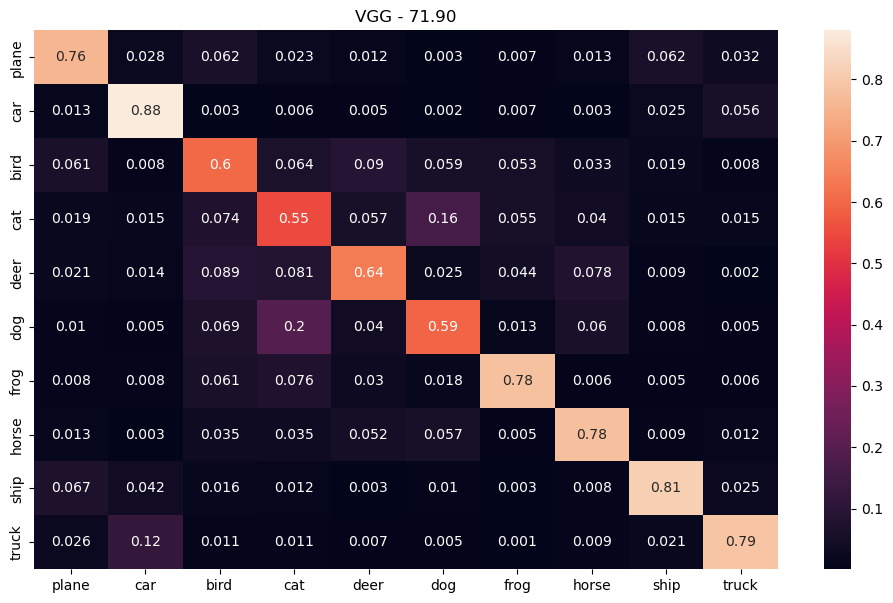

In [14]:
vgg = VGG(3, 10)

#################################################
# TODO: Change the path to the path of your     #
# trained VGG model.                            #
#################################################
cktp = './runs/VGG/checkpoints_vgg/checkpoint_19_71.9000.pth'
vgg.load_checkpoint(cktp, map_location=device)

plot_confusion_matrix(vgg, val_loader, class_names, device)

In [ ]:
resnet = ResNet(BasicBlock, num_blocks=[1, 2, 2, 1], num_classes=10)

if device == "cuda":
    resnet = resnet.to(device)
    print("Using GPU")

#################################################
# TODO: Change the path to the path of your     #
# trained ResNet model.                         #
#################################################
cktp = "./runs/ResNet/checkpoints_resnet/checkpoint_25_84.3400.pth"
resnet.load_checkpoint(cktp, map_location=device)

plot_confusion_matrix(resnet, val_loader, class_names, device)

Using GPU


FileNotFoundError: [Errno 2] No such file or directory: './runs/ResNet/checkpoints_resnet/checkpoint_19_84.0400.pth'